In [1]:
# import packages
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# import nbody6tools reader to read data
from nbody6tools import Reader

# import nbody62spisea to retrieve star ages
from nbody62spisea import converter

/home/wyz5rge/.local/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /scratch/wyz5rge/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Set up parameters, create isochrone grid

In [2]:
# define isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.MergedBaraffePisaEkstromParsec()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F115W', 'jwst,F182M']
filters = ['m_jwst_F115W', 'm_jwst_F182M']
iso_dir = 'isochrones/'
metallicity = 0

# Select nbody6 simulation and snapshot, then convert to physical units and save as a cluster table which SPISEA can interface with

In [3]:
# read nbody data
path_to_data = '../../../../../../storage/jfarias/Data/Orion/massive_clusters/M3000new/sigma1p0/fiducial/sfe_ff100/00/'
snapshot = Reader.read_snapshot(path_to_data, time = 1.5)

# convert snapshot values from nbody units to astrophysical, extract masses
snapshot.to_physical()
cluster_table = converter.to_spicea_table(snapshot)

print(cluster_table)

        mass        isMultiple        compMass            systemMass             e                log_a               age        
------------------- ---------- --------------------- ------------------- ------------------ ------------------ ------------------
  56.24521950614411        0.0                    []   56.24521950614411                nan                nan  1.494411190854979
0.11411525852041825        0.0                    [] 0.11411525852041825                nan                nan 1.5011385289993755
  12.96283688892593        0.0                    []   12.96283688892593                nan                nan 1.4970749668953602
0.27321673034539384        0.0                    [] 0.27321673034539384                nan                nan 1.4964816285263873
                ...        ...                   ...                 ...                ...                ...                ...
0.20449300038109305        1.0 [0.11248395795903553] 0.31697695834012857   0.2989732941710

# Read ages of stars, identify bracketing ages for isochrone generation
Also save mass of stars

In [4]:
masses = cluster_table['mass']
level_ages = cluster_table['age']

for i in range(len(level_ages)):
    level_ages[i] = level_ages[i] * 1e6

# convert log ages from log(Myr) to log(yr)
log_ages = np.log10(level_ages)

# print(log_ages)
print("Min log age = " + str(min(log_ages)))
print("Max log age = " + str(max(log_ages)))

# print(level_ages)
print("Min level age = " + str(min(level_ages)))
print("Max level age = " + str(max(level_ages)))

Min log age = 6.172382928762329
Max log age = 6.182058450993647
Min level age = 1487246.4082493563
Max level age = 1520752.191543579


# Identify binary stars in cluster table, save mass of companion stars

Cluster table always lists binaries last, so finding the index of the first binary suffices

In [5]:
# find index of first binary, create array of companion masses
first_binary = 0
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        first_binary = i
        break
# print(first_binary)

compMasses = []
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        compMasses.append(cluster_table['compMass'][i][0])
# print(compMasses)

# Create histogram of mass ratios pre-processing

(array([  3.,  14.,  69., 121., 181., 124., 134., 141., 120., 132.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 20 artists>)

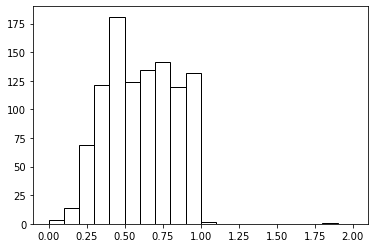

In [6]:
ratios = []
for i in range(len(compMasses)):
    ratios.append(compMasses[i] / masses[i + first_binary])
    # print(ratios[i])

py.hist(ratios, bins=20, range=[0, 2], fill=False)

# Generate isochrones using parameter and age arrays

In [7]:
start = (min(level_ages) // 0.5e6) * 0.5e6
end = (max(level_ages) // 0.5e6) * 0.5e6 + 2 * 0.5e6
increment = 0.5e6  # 500,000

# Create age arrays
level_age_arr = np.arange(start, end, increment)
log_age_arr = np.log10(level_age_arr)

print(log_age_arr)
print(level_age_arr)

[6.         6.17609126 6.30103   ]
[1000000. 1500000. 2000000.]


In [8]:
# create isochrone grid - if this is the first time, then this is going to take an hour lmfao
instances = np.empty(len(log_age_arr), dtype=object)

for i in range(len(log_age_arr)):
    my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso
        
print("isochrone generation done")

Changing to logg=4.50 for T= 39129 logg=4.17
Changing to logg=4.50 for T= 39301 logg=4.17
Changing to logg=4.50 for T= 39464 logg=4.17
Changing to logg=4.50 for T= 39637 logg=4.16
Changing to logg=4.50 for T= 39802 logg=4.16
Changing to logg=4.50 for T= 39976 logg=4.16
Changing to logg=4.50 for T= 40142 logg=4.16
Changing to logg=4.50 for T= 40300 logg=4.16
Changing to logg=4.50 for T= 40309 logg=4.16
Changing to logg=4.50 for T= 40448 logg=4.15
Changing to logg=4.50 for T= 40588 logg=4.15
Changing to logg=4.50 for T= 40729 logg=4.15
Changing to logg=4.50 for T= 40870 logg=4.15
Changing to logg=4.50 for T= 41011 logg=4.15
Changing to logg=4.50 for T= 41153 logg=4.14
Changing to logg=4.50 for T= 41295 logg=4.14
Changing to logg=4.50 for T= 41438 logg=4.14
Changing to logg=4.50 for T= 41581 logg=4.14
Changing to logg=4.50 for T= 41601 logg=4.14
Changing to logg=4.50 for T= 41697 logg=4.14
Changing to logg=4.50 for T= 41812 logg=4.13
Changing to logg=4.50 for T= 41918 logg=4.13
Changing t

Changing to logg=4.50 for T= 44648 logg=4.03
Changing to logg=4.50 for T= 44720 logg=4.03
Changing to logg=4.50 for T= 44802 logg=4.03
Changing to logg=4.50 for T= 44885 logg=4.03
Changing to logg=4.50 for T= 44957 logg=4.03
Changing to logg=4.50 for T= 45040 logg=4.03
Changing to logg=4.50 for T= 45113 logg=4.03
Changing to logg=4.50 for T= 45698 logg=4.03
Changing to logg=4.50 for T= 47000 logg=4.02
Changing to logg=4.50 for T= 48473 logg=4.03
Changing to T= 50000 for T= 50061 logg=4.04
Changing to logg=5.00 for T= 50061 logg=4.04
Changing to T= 50000 for T= 51618 logg=4.06
Changing to logg=5.00 for T= 51618 logg=4.06
Changing to T= 50000 for T= 53015 logg=4.07
Changing to logg=5.00 for T= 53015 logg=4.07
Changing to T= 50000 for T= 53691 logg=4.07
Changing to logg=5.00 for T= 53691 logg=4.07
Changing to T= 50000 for T= 54013 logg=4.06
Changing to logg=5.00 for T= 54013 logg=4.06
Changing to T= 50000 for T= 53839 logg=4.03
Changing to logg=5.00 for T= 53839 logg=4.03
Changing to T= 5

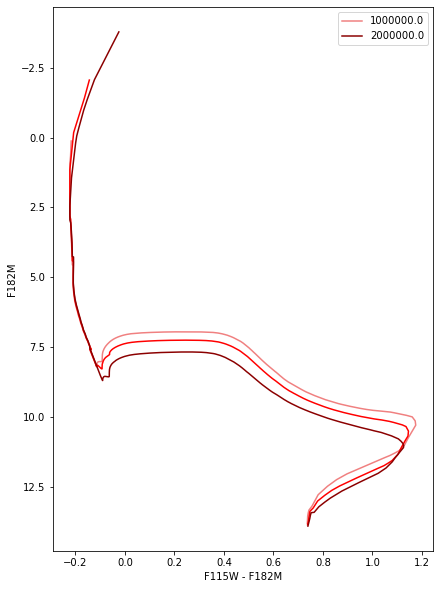

In [9]:
# identify array indeces, create array for labels and colors
idx_arr = range(0, len(log_age_arr))
if len(idx_arr) > 3:
    idx_arr = idx_arr[::2]

# Plot CMD
fig, axes = py.subplots(figsize=(15, 10))
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

# Use generated SPISEA isochrones to find interpolated magnitudes using the age and mass of each star

Stars outside of the mass range of isochrones are thrown out and not included

In [11]:
import sys
sys.path.append('/scratch/wyz5rge/synthetic-hr/')
import interpolator as interpolator

level_ages_myr = level_ages / 1e6
# print(level_ages_myr)

# create array of stars
stars = np.empty(len(cluster_table), dtype=object)

# perform interpolation for each star
for i in range(len(stars)):
    # print(str(i) + " " + str(level_ages_myr[i]) + " " + str(masses[i]))
    print(masses[i])
    stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
# convert luminosity values to solar luminosities
watts_to_lsun = 1.0 / (3.846e26) # conversion factor for watts to Lsun

for i in range(len(stars)):
    if stars[i] is None:
        continue
    stars[i][0] = stars[i][0] * watts_to_lsun
    
# for i in range(len(stars)):
    # print(stars[i])

56.24521950614411
0.11411525852041825
12.96283688892593
0.27321673034539384
0.23029620900072592
0.3058690028542314
14.494145017213652
0.07746465814392134
0.3033320386270977
0.23707198644689903
0.5406400905452182
0.08466339817270757
0.08217508690946722
0.09649129577108034
0.1218827075342136
0.0428821459115702
7.626421404264792
0.3185423488147625
0.09262585734238067
0.07831495046053252
0.06854727299807327
0.06595964158779352
0.32401476883743635
0.6940341505686082
4.670821086511905
0.03596118908043647
0.13224648705948092
0.1301259300395802
1.5874859352395498
1.15214260274077
0.0888019516599983
0.04026427678734667
0.020623492485525405
0.013441907171553627
0.013963342355376863
0.010155555829989275
0.4747327107825938
0.25384276708828524
0.3903097343589968


ValueError: can only convert an array of size 1 to a Python scalar

# Repeat interpolation on companion stars

Companion stars assumed to be the same age as primary star within system

In [ ]:
# perform interpolation on companion stars
companions = np.empty(len(compMasses), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None:
        continue
    companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

for i in range(len(companions)):
    if companions[i] is None:
        continue
    companions[i][0] = companions[i][0] * watts_to_lsun
    
count = 0
for i in range(len(companions)):
    if companions[i] is None:
        count = count + 1
        continue
    # print(companions[i])

print(count)
print(len(companions))


# Determine mass ratios after filtering, create plots

In [ ]:
new_ratios = []
for i in range(len(companions)):
    if companions[i] is None:
        continue
    new_ratios.append(compMasses[i] / masses[i + first_binary])


In [ ]:
py.hist(ratios, bins=20, range=[0,2], fill=False)

In [ ]:
py.hist(new_ratios, bins=20, range=[0,2], fill=False)

# Superimpose primary stars and companion stars against isochrones separately

In [ ]:
# plot primaries and companions separately
fig, axes = py.subplots(figsize=(15, 10))

# plot primaries
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.title('CMD of primary stars only')
py.legend()

# plot companions
py.subplot(1, 2, 2)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
        
for i in range(len(companions)):
    if companions[i] is None:
        continue
    py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.title('CMD of companion stars only, post-filtering')
py.legend()

# Convert binary stars into unresolved binaries
## Also compute flux ratios of stars and generate histogram
Magnitudes of primary and secondary are converted into flux, which is used to find combined magnitude

In [ ]:
# combine magnitudes on binary stars
unresolved_binaries = np.empty(len(companions), dtype=object)

flux_ratios = []

for i in range(len(companions)):
    if stars[i + first_binary] is None or companions[i] is None:
        continue
    
    flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
    flux21 = np.power(10, companions[i][3] / -2.5) * 3.93e-10
    flux_ratios.append(flux11 / flux21)
    mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)
    
    flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 7.44e-11
    flux22 = np.power(10, companions[i][4] / -2.5) * 7.44e-11
    mag2 = -2.5 * np.log10((flux12 + flux22) / 7.44e-11)
    
    unresolved_binaries[i] = [mag1, mag2]

In [ ]:
py.hist(flux_ratios, bins=30, range=[0,10])

# Generate CMD using star array, plus unresolved binaries
Compare to CMD generated by simply multiplying each star's flux by 2

In [ ]:
fig, axes = py.subplots(figsize=(15, 10))

# plot CMD
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.title('CMD of stars with unresolved binaries')
py.legend()

# plot single stars first
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

# plot unresolve binaries
for i in range(len(unresolved_binaries)):
    if unresolved_binaries[i] is None:
        continue
    py.plot(unresolved_binaries[i][0] - unresolved_binaries[i][1], unresolved_binaries[i][1], marker='o', markersize=1, color='green')
    
for i in range(len(stars)):
    if stars[i] is None:
        continue
    x = -2.5 * np.log10(2 * np.power(10, stars[i][4] / -2.5))
    py.plot(stars[i][3] - stars[i][4], x, marker='o', markersize=1, color='blue')
    
# plot toy scalar multiple track
py.subplot(1, 2, 2)

# plot isochrone curves
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')

# plot primary stars
for i in range(len(stars)):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
# plot magnitude of each star if its flux was double
for i in range(len(stars)):
    if stars[i] is None:
        continue
    x = -2.5 * np.log10(2 * np.power(10, stars[i][4] / -2.5))
    py.plot(stars[i][3] - stars[i][4], x, marker='o', markersize=1, color='blue')

py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.title('CMD with scalar multiple track')
py.legend()

# Test CMD generation with different mass ratios

In [ ]:
# Generate array of manually-set companion masses with the ratios: 1, 0.5, 0.25
compMasses1p0 = []
compMasses0p5 = []
compMasses0p25 = []
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        compMasses1p0.append(masses[i])
        compMasses0p5.append(masses[i] * 0.5)
        compMasses0p25.append(masses[i] * 0.25)

In [ ]:
# Perform interpolation on mass-controlled companion masses
companions1p0 = np.empty(len(compMasses), dtype=object)
companions0p5 = np.empty(len(compMasses), dtype=object)
companions0p25 = np.empty(len(compMasses), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None:
        continue
    companions1p0[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses1p0[i], instances, log_age_arr, filters)
    companions0p5[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses0p5[i], instances, log_age_arr, filters)
    companions0p25[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses0p25[i], instances, log_age_arr, filters)
    
# count stars thrown out
count1p0 = 0
count0p5 = 0
count0p25 = 0
for i in range(len(companions)):
    if companions1p0[i] is None:
        count1p0 = count1p0 + 1
        continue
    if companions0p5[i] is None:
        count0p5 = count0p5 + 1
        continue
    if companions0p25[i] is None:
        count0p25 = count0p25 + 1
        continue

print(count1p0)
print(count0p5)
print(count0p25)

In [ ]:
# combine flux on binary stars to find magnitude of unresolved system
unresolved_binaries1p0 = np.empty(len(companions), dtype=object)
unresolved_binaries0p5 = np.empty(len(companions), dtype=object)
unresolved_binaries0p25 = np.empty(len(companions), dtype=object)

flux_ratios1p0 = []
flux_ratios0p5 = []
flux_ratios0p25 = []

for i in range(len(companions)):
    if stars[i + first_binary] is None or companions1p0[i] is None:
        continue
    
    flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
    flux21 = np.power(10, companions1p0[i][3] / -2.5) * 3.93e-10
    flux_ratios1p0.append(flux11 / flux21)
    mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)
    
    flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 7.44e-11
    flux22 = np.power(10, companions1p0[i][4] / -2.5) * 7.44e-11
    mag2 = -2.5 * np.log10((flux12 + flux22) / 7.44e-11)
    
    unresolved_binaries1p0[i] = [mag1, mag2]
    
for i in range(len(companions)):
    if stars[i + first_binary] is None or companions0p5[i] is None:
        continue
    
    flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
    flux21 = np.power(10, companions0p5[i][3] / -2.5) * 3.93e-10
    flux_ratios0p5.append(flux11 / flux21)
    mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)

    flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 7.44e-11
    flux22 = np.power(10, companions0p5[i][4] / -2.5) * 7.44e-11
    mag2 = -2.5 * np.log10((flux12 + flux22) / 7.44e-11)
    unresolved_binaries0p5[i] = [mag1, mag2]

    
for i in range(len(companions)):
    if stars[i + first_binary] is None or companions0p25[i] is None:
        continue
    
    flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
    flux21 = np.power(10, companions0p25[i][3] / -2.5) * 3.93e-10
    flux_ratios0p25.append(flux11 / flux21)
    mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)
    
    flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 7.44e-11
    flux22 = np.power(10, companions0p25[i][4] / -2.5) * 7.44e-11
    mag2 = -2.5 * np.log10((flux12 + flux22) / 7.44e-11)
    
    unresolved_binaries0p25[i] = [mag1, mag2]

In [ ]:
py.subplot(1, 3, 1)
py.hist(flux_ratios1p0, range=[0,10])

py.subplot(1, 3, 2)
py.hist(flux_ratios0p5, range=[0,10])

py.subplot(1, 3, 3)
py.hist(flux_ratios0p25, range=[0,10])

In [ ]:
fig, axes = py.subplots(figsize=(20, 10))

# plot equal mass CMD
py.subplot(1, 3, 1)

# plot isochrone curves
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')

# plot single stars first
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

# plot unresolve binaries
for i in range(len(unresolved_binaries1p0)):
    if unresolved_binaries1p0[i] is None:
        continue
    py.plot(unresolved_binaries1p0[i][0] - unresolved_binaries1p0[i][1], unresolved_binaries1p0[i][1], marker='o', markersize=1, color='green')
    

for i in range(len(stars)):
    if stars[i] is None:
        continue
    x = -2.5 * np.log10(2 * np.power(10, stars[i][4] / -2.5))
    py.plot(stars[i][3] - stars[i][4], x, marker='o', markersize=1, color='blue')

py.plot(stars[756][3] - stars[756][4], stars[756][4], 'k*', ms=15, label='1 $M_\odot$')
  
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.title('Companions forced to equal mass')
py.legend()
    
# plot 0.5 mass ratio CMD
py.subplot(1, 3, 2)

# plot isochrone curves
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')

# plot single stars first
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
# plot unresolve binaries
for i in range(len(unresolved_binaries0p5)):
    if unresolved_binaries0p5[i] is None:
        continue
    py.plot(unresolved_binaries0p5[i][0] - unresolved_binaries0p5[i][1], unresolved_binaries0p5[i][1], marker='o', markersize=1, color='green')

for i in range(len(stars)):
    if stars[i] is None:
        continue
    x = -2.5 * np.log10(2 * np.power(10, stars[i][4] / -2.5))
    py.plot(stars[i][3] - stars[i][4], x, marker='o', markersize=1, color='blue')

py.plot(stars[1441][3] - stars[1441][4], stars[1441][4], 'k*', ms=15, label='0.2 $M_\odot$')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.title('Companions forced to 0.5 mass of primary')
py.legend()

# plot 0.25 mass ratio CMD
py.subplot(1, 3, 3)

# plot isochrone curves
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')

# plot single stars first
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

# plot unresolve binaries
for i in range(len(unresolved_binaries0p25)):
    if unresolved_binaries0p25[i] is None:
        continue
    py.plot(unresolved_binaries0p25[i][0] - unresolved_binaries0p25[i][1], unresolved_binaries0p25[i][1], marker='o', markersize=1, color='green')

for i in range(len(stars)):
    if stars[i] is None:
        continue
    x = -2.5 * np.log10(2 * np.power(10, stars[i][4] / -2.5))
    py.plot(stars[i][3] - stars[i][4], x, marker='o', markersize=1, color='blue')
    
py.plot(stars[1680][3] - stars[1680][4], stars[1680][4], 'k*', ms=15, label='0.4 $M_\odot$')

py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.title('Companions forced to 0.25 mass of primary')
py.legend()